In [1]:
from loadmodules import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as mcolors
import scipy as sp
from sklearn.mixture import GaussianMixture

%matplotlib inline
rcParams['figure.facecolor'] = 'white'
# plt.rcParams.update({
#     "text.usetex": True
# })

In [2]:
path = './'
original_mw = sorted([directory for directory in os.listdir(path) if 'Au' in directory and 'cfea_fiducial' in directory])
lowmass_mw = sorted([directory for directory in os.listdir(path) if 'L' in directory and 'cfea_fiducial' in directory])
dwarfs = sorted([directory for directory in os.listdir(path) if 'D' in directory and 'cfea_fiducial' in directory])

simulation_list = original_mw + lowmass_mw + dwarfs

In [3]:
# path = './'
# simulation_list = sorted([directory for directory in os.listdir(path) if 'Au06' in directory and 'cfea' in directory])
# simulation_list.remove('Au06_lvl4_cfea_sh200myr10')

In [4]:
baseline_sim = 'Au06_lvl4_cfea_scbase'
simulation_list.append(baseline_sim)

In [5]:
simulation_list

['Au06_lvl4_cfea_fiducial',
 'Au14_lvl4_cfea_fiducial',
 'Au18_lvl4_cfea_fiducial',
 'Au22_lvl4_cfea_fiducial',
 'Au23_lvl4_cfea_fiducial',
 'Au24_lvl4_cfea_fiducial',
 'Au26_lvl4_cfea_fiducial',
 'Au27_lvl4_cfea_fiducial',
 'Au28_lvl4_cfea_fiducial',
 'L01_lvl4_cfea_fiducial',
 'L10_lvl4_cfea_fiducial',
 'D04_lvl4_cfea_fiducial',
 'D07_lvl4_cfea_fiducial',
 'D10_lvl4_cfea_fiducial',
 'Au06_lvl4_cfea_scbase']

Loading simulation  Au06_lvl4_cfea_fiducial  snapshot  127
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
GMM Label for Spheroid: 0


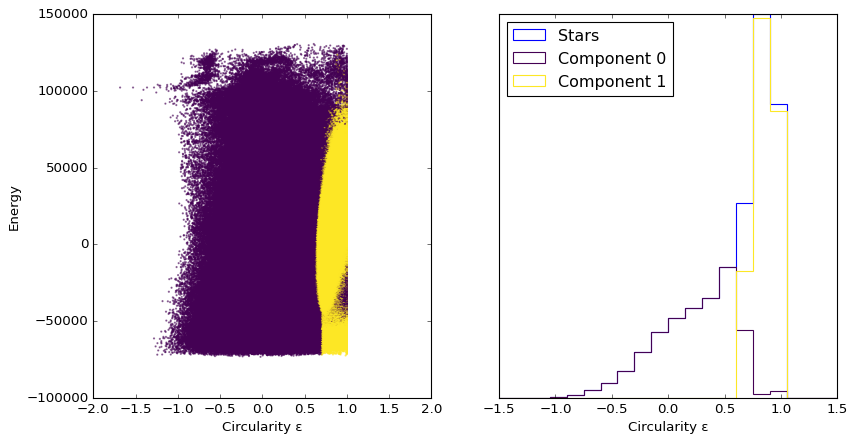

Loading simulation  Au14_lvl4_cfea_fiducial  snapshot  127
galrad= 0.024826176
Found 2875263 stars.
Rotated pos.
Rotated vel.
GMM Label for Spheroid: 0


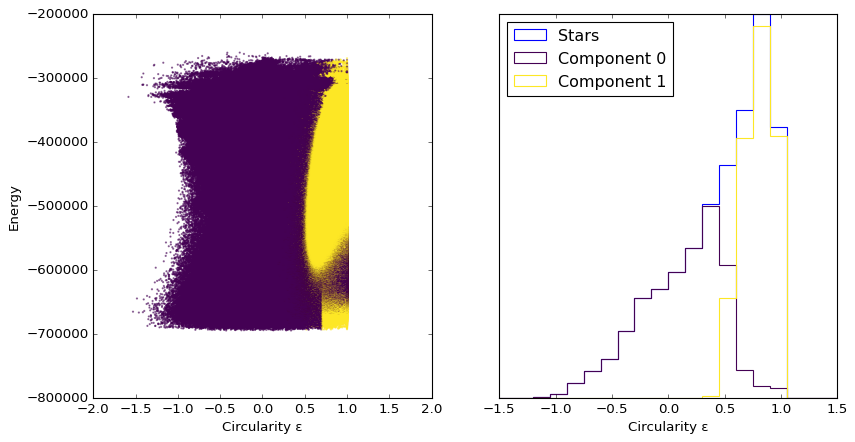

Loading simulation  Au18_lvl4_cfea_fiducial  snapshot  127
galrad= 0.021988682
Found 1937847 stars.
Rotated pos.
Rotated vel.
GMM Label for Spheroid: 0


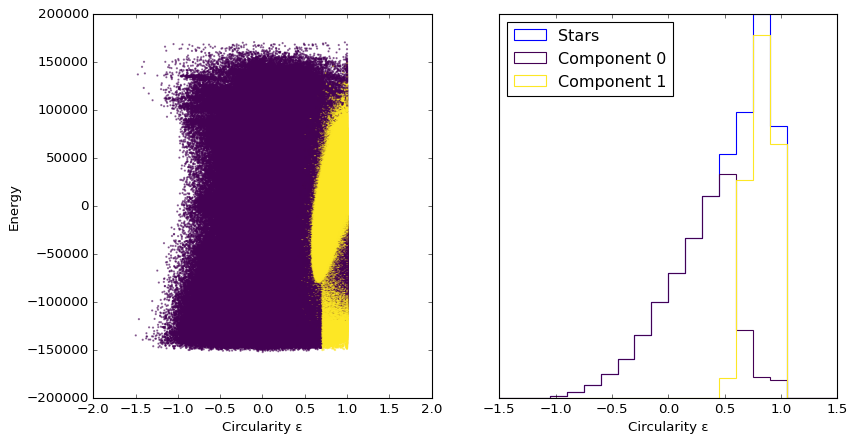

Loading simulation  Au22_lvl4_cfea_fiducial  snapshot  127
galrad= 0.020834247
Found 1527247 stars.
Rotated pos.
Rotated vel.
GMM Label for Spheroid: 0


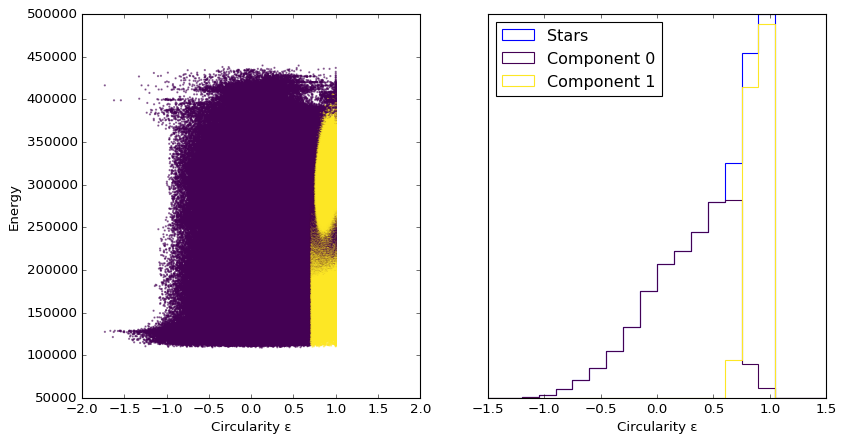

Loading simulation  Au23_lvl4_cfea_fiducial  snapshot  127
galrad= 0.024249291
Found 1704041 stars.
Rotated pos.
Rotated vel.
GMM Label for Spheroid: 0


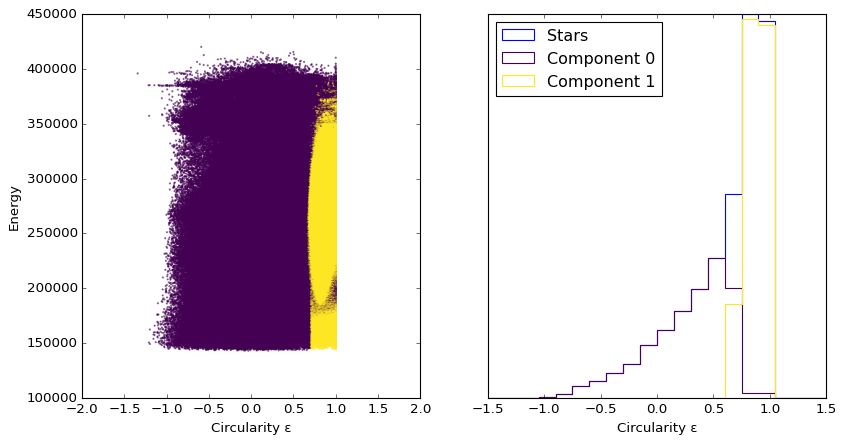

Loading simulation  Au24_lvl4_cfea_fiducial  snapshot  127
galrad= 0.024267228
Found 1735362 stars.
Rotated pos.
Rotated vel.
GMM Label for Spheroid: 0


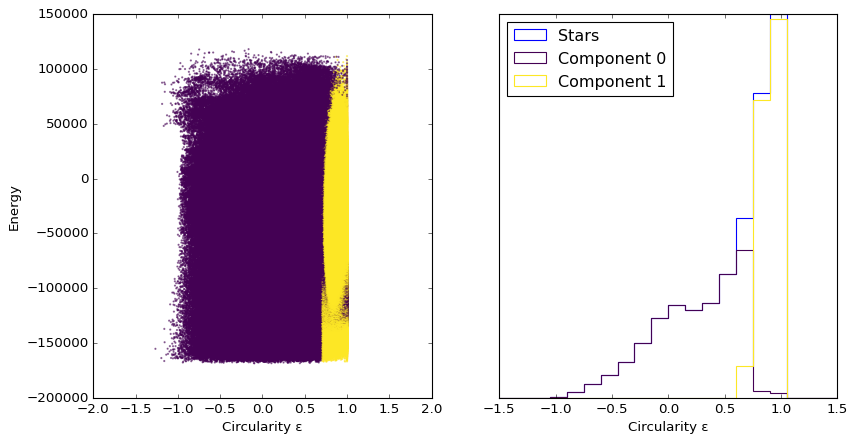

Loading simulation  Au26_lvl4_cfea_fiducial  snapshot  127
galrad= 0.02422835
Found 2664011 stars.
Rotated pos.
Rotated vel.
GMM Label for Spheroid: 0


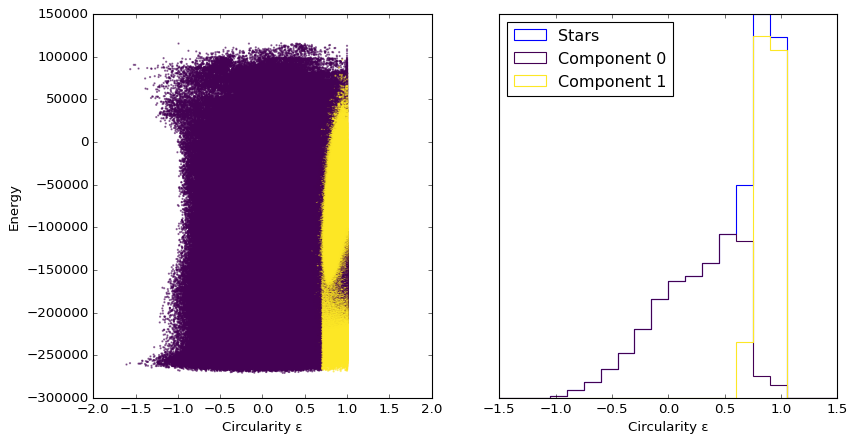

Loading simulation  Au27_lvl4_cfea_fiducial  snapshot  127
galrad= 0.025470624
Found 2678961 stars.
Rotated pos.
Rotated vel.
GMM Label for Spheroid: 0


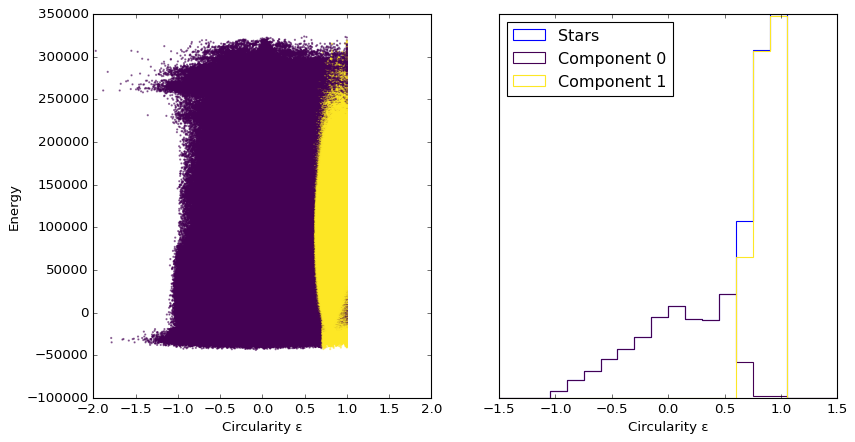

Loading simulation  Au28_lvl4_cfea_fiducial  snapshot  127
galrad= 0.024573132
Found 2686170 stars.
Rotated pos.
Rotated vel.
GMM Label for Spheroid: 0


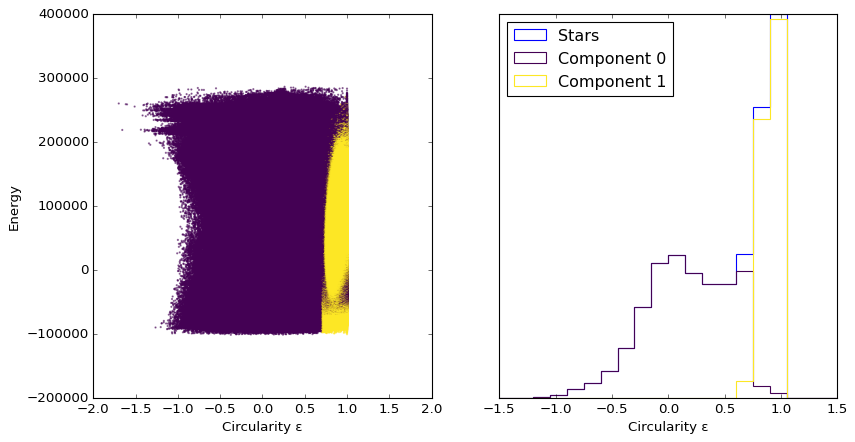

Loading simulation  L01_lvl4_cfea_fiducial  snapshot  127
galrad= 0.01654307
Found 352061 stars.
Rotated pos.
Rotated vel.
GMM Label for Spheroid: 0


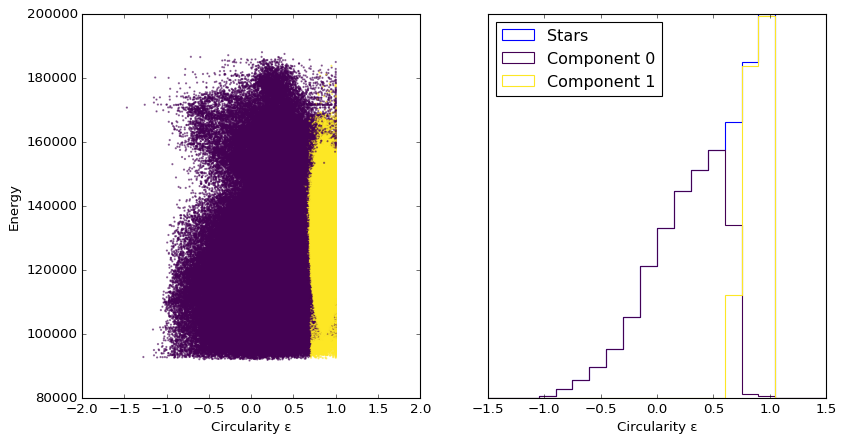

Loading simulation  L10_lvl4_cfea_fiducial  snapshot  127
galrad= 0.018846704
Found 974505 stars.
Rotated pos.
Rotated vel.
GMM Label for Spheroid: 0


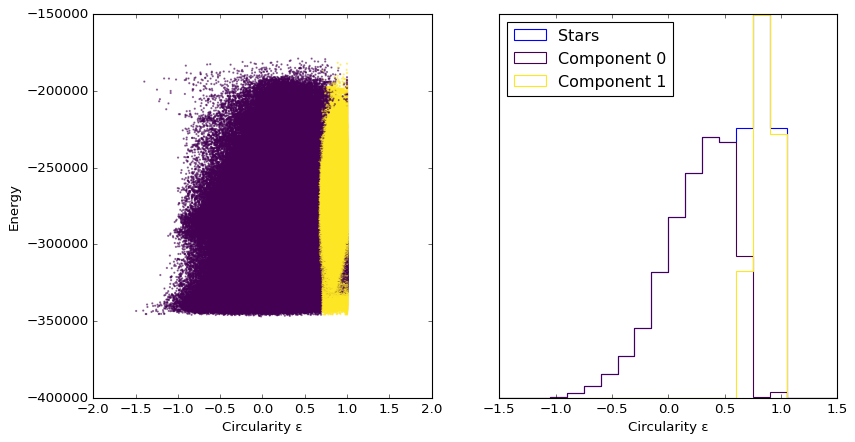

Loading simulation  D04_lvl4_cfea_fiducial  snapshot  127
galrad= 0.013944975
Found 189757 stars.
Rotated pos.
Rotated vel.
GMM Label for Spheroid: 0


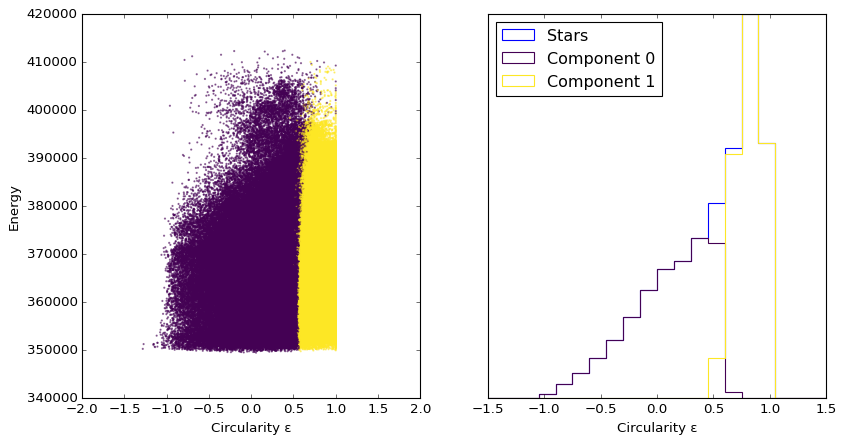

Loading simulation  D07_lvl4_cfea_fiducial  snapshot  127
galrad= 0.0114392955
Found 124505 stars.
Rotated pos.
Rotated vel.
GMM Label for Spheroid: 0


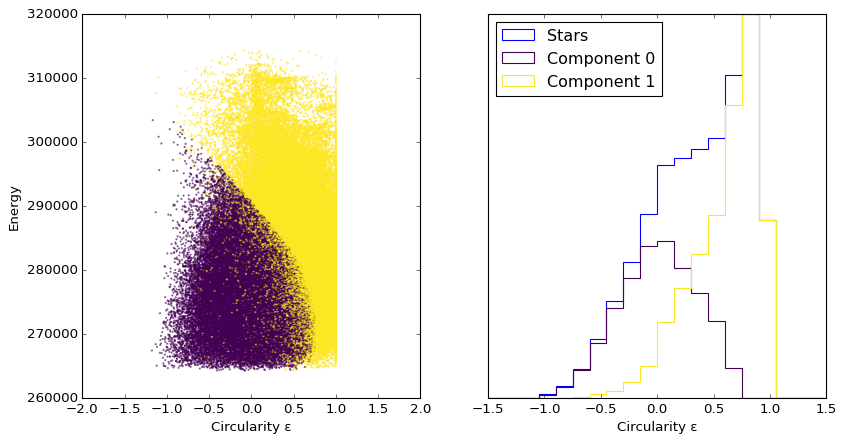

Loading simulation  D10_lvl4_cfea_fiducial  snapshot  127
galrad= 0.01
Found 84032 stars.
Rotated pos.
Rotated vel.
GMM Label for Spheroid: 0


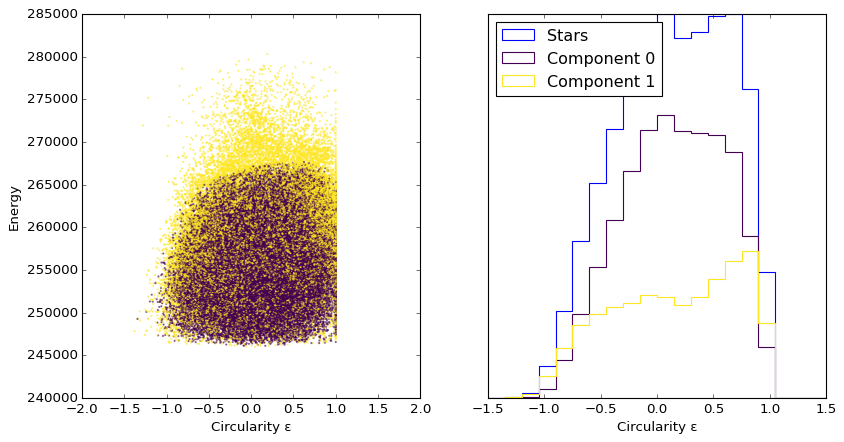

Loading simulation  Au06_lvl4_cfea_scbase  snapshot  127
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
GMM Label for Spheroid: 0


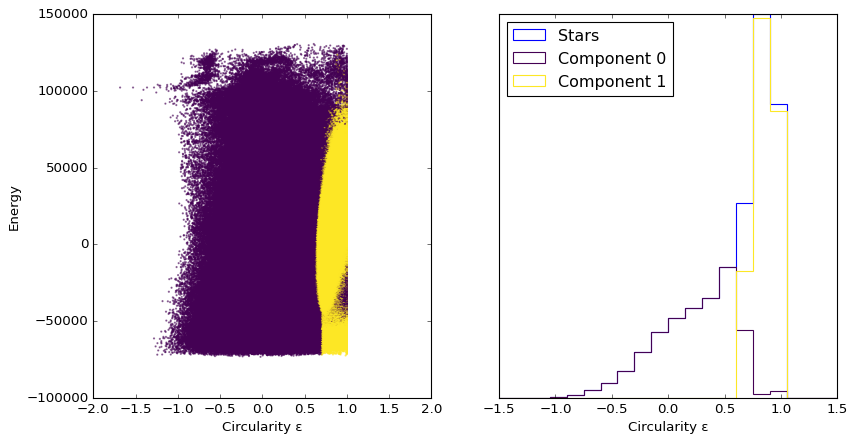

In [6]:
halo_masses = []
gc_system_masses = []
halo_info = []

for sim in simulation_list:
    snap_id = 127
    print('Loading simulation ', sim, ' snapshot ', snap_id)
    sf = load_subfind(snap_id, dir=path+sim+'/output/', hdf5=True, loadonly=['fpos', 'fmc2', 'frc2', 'svel', 'flty', 'fmty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
    s = gadget_readsnap(snap_id, snappath=path+sim+'/output/', subfind=sf, hdf5=True, applytransformationfacs=True, loadonlyhalo=0, loadonlytype=[4])
    s.calc_sf_indizes( sf )
    s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )
    galrad = sf.data['frc2'][0]

    halo_masses.append(sf.data['fmc2'][0]*1e10) # in Msun

    starparts = (s.data['age']>0.) * (s.r() < galrad) * (s.data['subhalo']==0)
    mask_clusters_initial = (s.data['incl'][starparts] > 0 ) * (s.r()[starparts] < galrad)
    
    Lz = pylab.cross( s.data['pos'], (s.data['vel'] ) )[:,0]
    orbital_energy = s.data['pot'] + 0.5 * np.sum(s.data['vel']**2, axis=1)
    jz = Lz[starparts]
    ii = np.argsort(orbital_energy[starparts])
    eps = jz[ii]
    npm = 50
    eps /= [ np.max(eps[:i+npm]) if i < npm else np.max(eps[i-npm:]) if i > size(ii)-npm else np.max(eps[i-npm:i+npm]) for i in range(size(ii)) ]
    ilist = np.array(list(range(0, len(eps))))# ilist=1,2,3,4,5
    ilist = ilist[ii] # ilist=5,4,3,2,1
    resort = np.argsort(ilist) # resort=5,4,3,2,1
    eps = eps[resort] # eps2=5,4,3,2,1

    # Build feature array: [ε, Energy]
    X = np.vstack((eps,orbital_energy[starparts],
                    np.log10(np.abs(s.data['pos'][:,0][starparts])))).T

    # Fit GMM
    gmm = GaussianMixture(n_components=2, means_init=[[0.0,np.median(orbital_energy[starparts]), -2.0],
                                                      [0.9,np.median(orbital_energy[starparts]), -3.0]],
                                                       covariance_type='full', random_state=42)
    gmm.fit(X)

    # Predict cluster memberships
    decomp_labels = gmm.predict(X)
    median_eps = [np.median(eps[decomp_labels==i]) for i in range(gmm.n_components)]
    sph_label = np.argmin(median_eps)
    disc_label = np.argmax(median_eps)

    #Force assign disc_label to clusters with high circularity
    mask = (decomp_labels == sph_label) & (eps > 0.7) & (s.r()[starparts] < np.percentile(s.r()[starparts][decomp_labels == disc_label], 0.75))
    decomp_labels[mask] = disc_label
    
    print('GMM Label for Spheroid:', sph_label)
    mask_decomposition = decomp_labels[mask_clusters_initial] == sph_label
    
    label_color = plt.cm.viridis(np.linspace(0, 1, 2))
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].scatter(eps, orbital_energy[s.data['type']==4][starparts],
                c=decomp_labels, s=1, cmap='viridis', alpha=0.5, edgecolors='face')
    ax[0].set(xlabel='Circularity ε', ylabel='Energy', xlim=(-2,2))

    ax[1].hist(eps, histtype='step', bins=20, range=[-1.5,1.5], label='Stars')
    for i in range(gmm.n_components):
        ax[1].hist(eps[(decomp_labels==i)], histtype='step', edgecolor=label_color[i], bins=20, range=[-1.5,1.5], label=f'Component {i}')
    ax[1].get_yaxis().set_ticks([])
    ax[1].legend(loc='upper left')
    ax[1].set_xlabel('Circularity ε')
    plt.show()

    cluster_masses = s.data['mclt'][starparts][mask_clusters_initial][mask_decomposition].flatten()
    init_cluster_masses = s.data['imcl'][starparts][mask_clusters_initial][mask_decomposition].flatten()
    
    not_empty_clusters = (init_cluster_masses>0.)

    cluster_masses = cluster_masses[not_empty_clusters]
    init_cluster_masses = init_cluster_masses[not_empty_clusters]

    clusters_formtime = np.repeat(s.data['age'][starparts][mask_clusters_initial][mask_decomposition], s.data['incl'][starparts][mask_clusters_initial][mask_decomposition])
    clusters_age = s.cosmology_get_lookback_time_from_a(clusters_formtime, is_flat=True) - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True)

    low_mass_cut = 1e5
    
    not_empty_clusters = (cluster_masses>0.)
    init_mass_cut = (1e10*init_cluster_masses[not_empty_clusters]>low_mass_cut)
    age_cut = (clusters_age[not_empty_clusters][init_mass_cut]>6.)

    gc_system_masses.append((1e10*cluster_masses[not_empty_clusters][init_mass_cut][age_cut]).sum()) # in Msun
    halo_info.append([sim, sf.data['fmc2'][0]*1e10, sf.data['frc2'][0]*1e3, sf.data['smty'][0][4]*1e10, gc_system_masses[-1]])

In [7]:
halo_masses = np.array(halo_masses)
gc_system_masses = np.array(gc_system_masses)
for info in halo_info:
    print(info)

['Au06_lvl4_cfea_fiducial', np.float32(1044976800000.0), np.float32(213.91646), np.float32(53512245000.0), np.float32(220127650.0)]
['Au14_lvl4_cfea_fiducial', np.float32(1633724800000.0), np.float32(248.26176), np.float32(123036950000.0), np.float32(424531330.0)]
['Au18_lvl4_cfea_fiducial', np.float32(1135025800000.0), np.float32(219.88683), np.float32(83970470000.0), np.float32(266003650.0)]
['Au22_lvl4_cfea_fiducial', np.float32(965550000000.0), np.float32(208.34247), np.float32(62669600000.0), np.float32(107901730.0)]
['Au23_lvl4_cfea_fiducial', np.float32(1522286700000.0), np.float32(242.4929), np.float32(84419625000.0), np.float32(251732160.0)]
['Au24_lvl4_cfea_fiducial', np.float32(1525648200000.0), np.float32(242.67229), np.float32(77070390000.0), np.float32(302833570.0)]
['Au26_lvl4_cfea_fiducial', np.float32(1518384400000.0), np.float32(242.2835), np.float32(107101890000.0), np.float32(449872130.0)]
['Au27_lvl4_cfea_fiducial', np.float32(1764046100000.0), np.float32(254.70624

In [8]:
halomass_gcmass_rel = np.genfromtxt('catalogues_compare/halo_gc_relation.txt', delimiter=',')

In [9]:
halobins = np.linspace(6.5, 14.5, 10)
halomass_gcmass_rel[halomass_gcmass_rel<3.5]=0.0
median_relation = []
sigma_low_relation = []
sigma_high_relation = []
for i in range(len(halobins)-1):
    mask = (halomass_gcmass_rel[:,0] > halobins[i]) & (halomass_gcmass_rel[:,0] < halobins[i+1])
    median_relation.append(np.median(halomass_gcmass_rel[mask,1]))
    sigma_low_relation.append(np.percentile(halomass_gcmass_rel[mask,1], 2.3))
    sigma_high_relation.append(np.percentile(halomass_gcmass_rel[mask,1], 97.7))

median_relation = np.array(median_relation)
sigma_low_relation = np.array(sigma_low_relation)
sigma_high_relation = np.array(sigma_high_relation)

spitler_forbes = halobins - 4.15
harris = halobins - 4.54

In [10]:
idx = []
for i in range(len(simulation_list)):
    if 'Au06' in simulation_list[i]:
        idx.append(i)

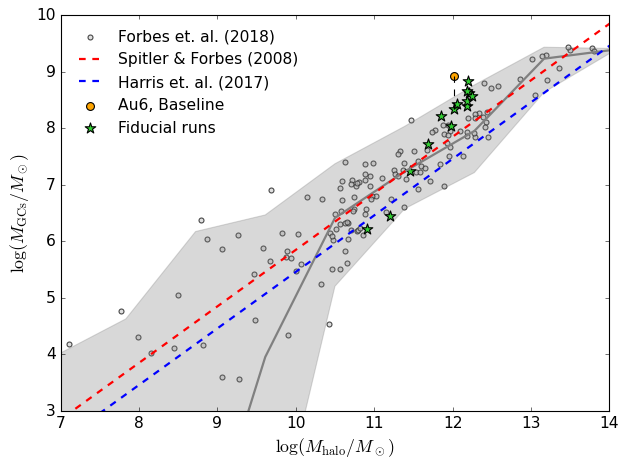

In [11]:
plt.scatter(halomass_gcmass_rel[:,0], halomass_gcmass_rel[:,1], c='lightgrey', label='Forbes et. al. (2018)', alpha=0.7)
plt.plot((halobins[1:]+halobins[:-1])/2., median_relation, color='grey', linewidth=2)
plt.fill_between((halobins[1:]+halobins[:-1])/2., sigma_low_relation, sigma_high_relation, color='grey', alpha=0.3)
plt.plot(halobins, spitler_forbes, color='r', linewidth=2, linestyle='dashed', label='Spitler & Forbes (2008)')
plt.plot(halobins, harris, color='b', linewidth=2, linestyle='dashed', label='Harris et. al. (2017)')
plt.plot([np.log10(halo_masses[idx[0]]), np.log10(halo_masses[idx[1]])],
         [np.log10(gc_system_masses[idx[0]]), np.log10(gc_system_masses[idx[1]])], color='k', linestyle='dashed', linewidth=1)
plt.scatter(np.log10(halo_masses[-1]), np.log10(gc_system_masses[-1]), color='orange', edgecolors='k', marker='o', s=50, label='Au6, Baseline')
plt.scatter(np.log10(halo_masses[:-1]), np.log10(gc_system_masses[:-1]), color='limegreen', edgecolors='k', marker='*', s=100, label='Fiducial runs')
plt.xlim(7, 14)
plt.ylim(3, 10)
plt.xlabel(r'$\log(M_{\rm{halo}}/M_\odot)$', fontsize=16)
plt.ylabel(r'$\log(M_{\rm{GCs}}/M_\odot)$', fontsize=16)
plt.legend(loc='upper left', fontsize=14, scatterpoints=1, frameon=False)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('./plots/halomass_gcmass_relation_paper.pdf', bbox_inches='tight')